In [62]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [63]:
df_owd = pd.read_csv("./dataset/openweatherdata-denpasar-1990-2020.csv", parse_dates=True) # , index_col=['dt_iso']
# df_owd = pd.read_csv("./dataset/2019.csv", parse_dates=True) # , index_col=['dt_iso']

In [64]:
df_owd = df_owd.drop(['dt', 'timezone', 'city_name', 'lat', 'lon', 'sea_level', 'grnd_level', 'rain_6h', 'rain_12h', 'rain_24h', 'rain_today', 'snow_1h', 'snow_3h', 'snow_6h', 'snow_12h', 'snow_24h', 'snow_today', 'weather_id', 'weather_description', 'weather_icon'], axis=1)
# df_owd = df_owd.drop(['dt', 'timezone', 'city_name', 'lat', 'lon', 'sea_level', 'grnd_level', 'rain_6h', 'rain_12h', 'rain_24h', 'rain_today', 'weather_id', 'weather_description', 'weather_icon'], axis=1)
df_owd.head()

,dt_iso,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,clouds_all,weather_main
0,1990-01-01 00:00:00 +0000 UTC,25.82,25.82,25.82,1010.0,86,1.36,225,0.49,NaN,98,Rain
1,1990-01-01 01:00:00 +0000 UTC,26.20,26.20,26.20,1011.0,84,2.09,247,0.13,NaN,91,Rain
2,1990-01-01 02:00:00 +0000 UTC,26.45,26.45,26.45,1011.0,84,2.44,262,0.24,NaN,94,Rain
3,1990-01-01 03:00:00 +0000 UTC,26.80,26.80,26.80,1011.0,82,2.29,271,0.23,NaN,94,Rain
4,1990-01-01 04:00:00 +0000 UTC,27.04,27.04,27.04,1010.0,82,1.71,274,NaN,NaN,76,Clouds


In [65]:
df_owd['dt_iso'] = df_owd['dt_iso'].map(lambda x: x.split(" +")[0])
df_owd['dt_iso'] = pd.to_datetime(df_owd['dt_iso'])

## Grouper

In [80]:
grouped = df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')])

### Aggregate Rainfall Rate per Day
Jika hari hujan maka ambil rain_1h,

jika rain_1h tak berisi maka ambil dari rain_3h dan tanpa perulangan

In [81]:
def total_hujan_hari(df):
    prev_rain = None
    acc = 0
    for index, row in df.iterrows():
        if row['weather_main'] == 'Rain':
            if not pd.isna(row['rain_1h']):
                acc = acc + row['rain_1h']
            elif not pd.isna(row['rain_3h']) and prev_rain != row['rain_3h']:
                acc = acc + row['rain_3h']
                prev_rain = row['rain_3h']
    return acc

total_1d = list()
for name, group in grouped:
    res = total_hujan_hari(group)
    total_1d.append(res)

total_1d = pd.Series(total_1d, name='rain_1d')


### Aggregate the rest

In [75]:
grouped_multiple = grouped.agg({'temp': 'mean', 'temp_min': ['min'], 'temp_max': ['max'], 'pressure': ['mean'], 'humidity': ['mean'],
                     'wind_speed': ['mean'], 'wind_deg': ['mean'], 'clouds_all': ['mean']}) 				 
grouped_multiple.columns = ["_".join(col_name).rstrip('_') for col_name in grouped_multiple.columns.to_flat_index()]
grouped_multiple = grouped_multiple.reset_index()
print(grouped_multiple)

          dt_iso  temp_mean  temp_min_min  temp_max_max  pressure_mean  \
0     1990-01-01  26.333750         25.03         27.40    1009.333333   
1     1990-01-02  25.559583         24.92         26.55    1009.666667   
2     1990-01-03  26.956667         26.09         27.52    1008.583333   
3     1990-01-04  26.638750         25.91         27.15    1007.958333   
4     1990-01-05  27.940417         27.40         28.83    1007.916667   
...          ...        ...           ...           ...            ...   
10959 2020-01-03  28.666667         27.00         31.00    1007.125000   
10960 2020-01-04  28.083333         27.00         30.00    1006.000000   
10961 2020-01-05  28.958333         27.00         31.00    1007.166667   
10962 2020-01-06  28.708333         28.00         30.00    1007.666667   
10963 2020-01-07  28.458333         27.00         30.00    1007.166667   

       humidity_mean  wind_speed_mean  wind_deg_mean  clouds_all_mean  
0          85.416667         1.477083  

In [76]:
aggregated_df = pd.concat([grouped_multiple, total_1d], axis=1)

In [78]:
aggregated_df.to_csv('1990-2020_day.csv', index=False)

In [71]:
# df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1h.sum()

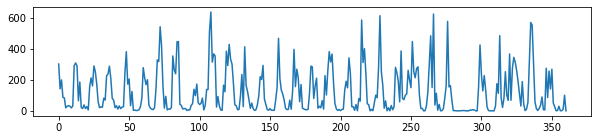

In [82]:
total_1d.plot()
plt.show()

ValueError: setting an array element with a sequence.

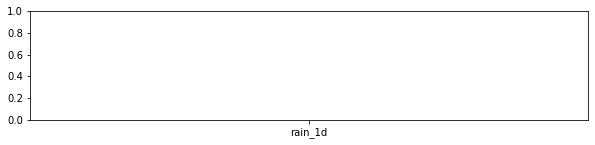

In [72]:

plt.rcParams['figure.figsize'] = [10, 2]
# plt.plot(df_owd.groupby([pd.Grouper(key='dt_iso', freq='M')]).rain_1h.sum(), marker='o')
plt.plot(total_1d, marker='o')
# plt.xticks([])
plt.ylabel("rain 1h")
plt.show()